<a href="https://colab.research.google.com/github/stonkpab/df-detect/blob/main/facial_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
from sklearn.model_selection import train_test_split
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

In [ ]:
#dataset dictionary based off faceforensics++ architecture
DATASET_PATHS = {
    'original': 'original_sequences/youtube',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
}

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = "/content/drive/My Drive/extracted2/"

Mounted at /content/drive


In [ ]:
#change directory to base_dir
os.chdir(base_dir)
!pwd

/content/drive/My Drive/extracted2


In [ ]:
#test for reading in images from drive
images = []
for path in DATASET_PATHS:
  if path == "original":
    img = cv2.imread(DATASET_PATHS[path] + "/raw/images/033/frame0.jpg")
  else:
    img = cv2.imread(DATASET_PATHS[path] + "/raw/images/033_097/frame0.jpg")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append([img,path])

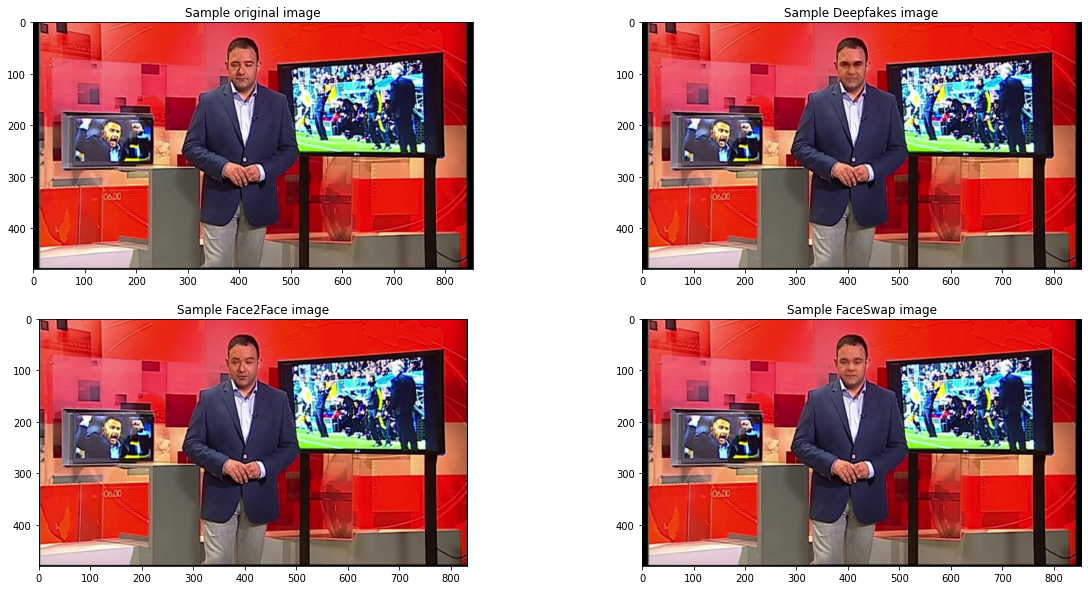

In [ ]:
#visualization using matplotlib
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Sample {} image".format(images[i][1]))
    plt.imshow(images[i][0])

In [ ]:
#facial extraction script into real and fake lists
real = []
fake = []
count = 0
for path in DATASET_PATHS:
  for seq in tqdm(os.listdir(DATASET_PATHS[path]+ "/raw/images/")): #progress bar per full video
    video_path = sorted(os.listdir(DATASET_PATHS[path]+"/raw/images/"+seq)) #keeps frames in chronological order
    for image in video_path:
      count += 1
      #img selection
      img = cv2.imread(DATASET_PATHS[path]+'/raw/images/'+seq+'/'+image)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      #face detection
      faces = face_detector(img, 0)
      if len(faces) == 0: #checks if face wasn't detected
        faces = face_detector(img, 1) #updates complexity
      if len(faces) != 0: #checks if face wasn't detected
        if len(faces) != 1: #checks for multiple faces
          areas = []
          for face in faces:
            x = face.left() 
            y = face.top()
            w = face.right() - x
            h = face.bottom() - y
            areas.append(w*h)
          #utilize face that covers most area in picture
          largest_index = areas.index(max(areas))
          faces = [faces[largest_index]]
        #crop out face and resize
        img = img[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()]
        img = cv2.resize(img,(299,299))
        #populate data with appropriate label
        if path == "original": #real = 0
          real.append(img)
        else:
          fake.append(img) #fake = 1
      else:
        print("Error at entry: " + str(count))

Error at entry: 5631
Error at entry: 5632
Error at entry: 5633
Error at entry: 5634
Error at entry: 5635



In [ ]:

len(real)

4995

In [ ]:
#account for discrepancy in size between real and fake
real = real[5:]
len(real)

4990

In [ ]:
len(fake)

4990

In [ ]:
#split off 500 image samples in sequences (100 videos) for test train split
#this needs to be done pre-shuffle to keep image frames with each other
real_train = real[500:]
real_test = real[:500]
fake_train = fake[500:]
fake_test = fake[:500]

#add real and fake data together and create target data (y) that matches the indices
X_train = real_train + fake_train
X_test = real_test + fake_test
Y_train = [0 if i < len(real_train) else 1 for i in range(len(X_train))]
Y_test = [0 if i < len(real_test) else 1 for i in range(len(X_test))]

#reshape into array
X_train = np.array(X_train).reshape(-1, 299, 299, 3)
X_test = np.array(X_test).reshape(-1, 299, 299, 3)

#preprocess input arrays according to xception
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [ ]:
X_train.shape

(8980, 299, 299, 3)

In [ ]:
X_test.shape

(1000, 299, 299, 3)

In [ ]:
!pwd

/content/drive/My Drive/extracted2


In [ ]:
!ls

manipulated_sequences  x_test.pkl   y_test.pkl
original_sequences     x_train.pkl  y_train.pkl


In [ ]:
#dump files into base_dir of google drive (x_train is extremely large- ensure if you have enough storage space)
joblib.dump(X_train, 'x_train.pkl')

['x_train.pkl']

In [ ]:
#dump rest of files
joblib.dump(X_test, 'x_test.pkl')
joblib.dump(Y_test, 'y_test.pkl')
joblib.dump(Y_train, 'y_train.pkl')

['y_train.pkl']